In [1]:
import os
from tqdm.notebook import tqdm
import polars as pl
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [28]:
# Existing dataset dir
data_dir = './data/'

# Existing plots dir
plots_dir = data_dir+'/plots/'
os.makedirs(data_dir, exist_ok=True)
os.makedirs(plots_dir, exist_ok=True)

LP_FEES = 0.0006 #5bps for  Uniswap and 1bps for Binance 6.0, 5.9 (6)


In [14]:
#def calculateV_MAX(reserves_ETH, price_AMM, price_CEX, f, g):
#    return abs((reserves_ETH * (price_AMM - price_CEX) / (2 * price_AMM)))

#def calculateMAV(reserves_ETH, price_AMM, price_CEX, f, g):
#    return (reserves_ETH * (price_AMM - price_CEX) ** 2 / (4 * price_AMM))


def calculateV_MAX(reserves_ETH, price_AMM, price_CEX, f=0.0005, g=0.0001):
    return pl.when(price_CEX > price_AMM).then(
        pl.when(((1 - g) * (1 - f) * price_CEX > price_AMM))
        .then(reserves_ETH * (1 - (price_AMM.pow(0.5) / ((1 - f) * (1 - g) * price_CEX).pow(0.5))))
        .otherwise(0)
    ).otherwise(
        pl.when((1 - g) * (1 - f) * price_AMM > price_CEX)
        .then(reserves_ETH / (1 - g) * (((1 - f) * (1 - g) * price_AMM).pow(0.5) / price_CEX.pow(0.5) - 1))
        .otherwise(0)
    )

def calculateMAV(reserves_ETH, price_AMM, price_CEX, f=0.0005, g=0.0001):
    return pl.when(price_CEX > price_AMM).then(
        pl.when(((1 - g) * (1 - f) * price_CEX > price_AMM))
        .then(reserves_ETH * (1 - f) * (((1 - g) * price_CEX).pow(0.5) - (price_AMM / (1 - f)).pow(0.5)) ** 2)
        .otherwise(0)
    ).otherwise(
        pl.when((1 - g) * (1 - f) * price_AMM > price_CEX)
        .then(reserves_ETH * (((1 - g) * price_CEX).pow(0.5) - (price_AMM / (1 - f)).pow(0.5)) ** 2)
        .otherwise(0)
    )



In [17]:
def process_swaps(swaps_df, fee):

    swaps_df = swaps_df.with_columns(
        price_diff = ((pl.col('spot_price') - pl.col('CEX_price')).abs()) / pl.col('CEX_price'),
        r_price_diff = (pl.col('spot_price') - pl.col('CEX_price')) / pl.col('CEX_price'),
        volume_total_USD = pl.col('amount_USD'),
        balance_total_USD = pl.col('amount_USD'),
        LP_Fee_USD = pl.col('amount_USD') * fee / 10000,
        LP_Fee_total_USD = (pl.col('amount_USD') * fee / 10000),
        LP_fee_p = (fee / 10000)
    )

    swaps_df = swaps_df.sort(by=['block_number', 'transaction_index'])

    swaps_df = swaps_df.with_columns(pl.col("balance_total_USD").cum_sum().over("block_number").alias("block_slippage_USD"))
    swaps_df = swaps_df.with_columns((pl.col("block_slippage_USD") - pl.col("balance_total_USD")).alias("block_slippage_USD"))

    #calulating MAV_0, V_max_0, reserve_total_0, LP_fee_0
    swaps_df = swaps_df.with_columns(
        MAV_USD = calculateMAV(pl.col('reserve_ETH'), pl.col('spot_price'), pl.col('CEX_price')),
        V_max_ETH = calculateV_MAX(pl.col('reserve_ETH'), pl.col('spot_price'), pl.col('CEX_price')),
        reserve_total_USD = 2 * pl.col('reserve_ETH')
    )

    swaps_df = swaps_df.with_columns(
        V_max_USD = pl.col('V_max_ETH') * pl.col('spot_price'),
    )


    #calculate threshold for max MAV as  Q3 + 1.5 IQR

    data = swaps_df['price_diff']
    # Calculate Q1 (25th percentile)
    Q1 = np.percentile(data, 25)
    # Calculate Q3 (75th percentile)
    Q3 = np.percentile(data, 75)
    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1
    threshold = Q3 #+ 1.5 * IQR
    print("threshold:", threshold)
    del(data)

    if (threshold < LP_FEES) : 
        threshold = LP_FEES
    print("threshold:", threshold)

    

    swaps_df = swaps_df.with_columns(
        MAV_threshold = pl.when(pl.col('price_diff') >  threshold).then(0).otherwise(1)
    )
    swaps_df = swaps_df.with_columns(
        MAV_cum_sum = pl.col('MAV_threshold').cum_sum()
    )
    swaps_df = swaps_df.with_columns(
        MAV_groups = pl.when(pl.col('MAV_threshold') >  0).then(0).otherwise(pl.col('MAV_cum_sum'))
    )

    # Perform the aggregation
    max_MAV_df = swaps_df.group_by('MAV_groups').agg(pl.max("MAV_USD").alias("max_MAV_USD"))

    # Join with the original DataFrame to get the corresponding block_timestamp
    max_MAV_df = max_MAV_df.join(
        swaps_df, on="MAV_groups", how="inner"
    ).select([
        "MAV_groups",
        "max_MAV_USD",
        "MAV_USD",
        "transaction_hash",
        "block_timestamp"
    ]).filter(pl.col("MAV_USD") == pl.col("max_MAV_USD")).filter(pl.col("MAV_groups") != 0)

    swaps_df = swaps_df.join(max_MAV_df, on="MAV_groups", how="left")

    swaps_df = swaps_df.with_columns(
        decay = pl.when(pl.col('block_timestamp') > pl.col('block_timestamp_right'))
                .then(pl.col('block_timestamp') - pl.col('block_timestamp_right'))
                .otherwise(pl.lit(0)),
        max_MAV_USD = pl.when(pl.col('transaction_hash') == pl.col('transaction_hash_right'))
                .then(pl.col('MAV_USD'))
                .otherwise(pl.lit(0))
    )
    return swaps_df

#getting the stats for Overleaf table
def get_arbitrage_stats(file_name, output_file, fee) :
    # Load the parquet file
    swaps_df = pl.scan_parquet(file_name).collect(streaming=True)
    swaps_df = process_swaps(swaps_df, fee)
    swaps_df.write_parquet(output_file)

    #swaps = swaps_df.shape[0]
    #swaps_df = swaps_df.with_columns(pl.col("max_MAV_USD").fill_null(0))
    total_MAX_MAV_USD = swaps_df['max_MAV_USD'].sum()
    total_MAV_USD = swaps_df['MAV_USD'].sum()
    total_volume_USD = abs(swaps_df['amount_USD']).sum()
    percent = total_MAX_MAV_USD / total_volume_USD
    percent_MAV = total_MAV_USD / total_volume_USD
    avg_decay = swaps_df['decay'].mean() / 1_000_000

    # Create formatted string
    my_row = f"\\num{{{total_MAX_MAV_USD:.2f}}} & \\num{{{total_volume_USD:.2f}}} & \\num{{{percent:.4f}}} & \\num{{{total_MAV_USD:.2f}}}& \\num{{{percent_MAV:.4f}}} & {avg_decay:.2}s"

    #For the second table
    MAV_df = swaps_df.filter(pl.col('max_MAV_USD') > 0)
    unique_MAV = MAV_df.shape[0]
    avg_MAV = MAV_df['max_MAV_USD'].median()
    avg_v_max = MAV_df['V_max_USD'].median()
    decay_df = swaps_df.filter(pl.col('decay') > 0)
    avg_decay = decay_df['decay'].mean() / 1_000_000

    my_row = f"\\num{{{unique_MAV}}} & \\num{{{avg_MAV:.2f}}} & \\num{{{avg_v_max:.4f}}} & {avg_decay:.2}s"
    return my_row


def get_arbitrate_by_day(file_name, fee) :

    swaps_df = pl.scan_parquet(file_name).collect(streaming=True)
    swaps_df = process_swaps(swaps_df, fee)
    # Define aggregation dictionary
    agg_expressions = {
        'volume_total_USD': pl.sum('volume_total_USD'),
        'price_diff': pl.max('price_diff'),
        'reserve_total_USD': pl.last('reserve_total_USD'),
        'spot_price': pl.last('spot_price'),
        'CEX_price': pl.last('CEX_price'),
        'MAV_USD': pl.sum('MAV_USD'),
        'max_MAV_USD': pl.sum('max_MAV_USD'),
        'LP_Fee_USD': pl.sum('LP_Fee_USD'),
        'decay': pl.max('decay'),
        #'fees_0': pl.sum('fees_0'),
        'LP_Fee_total_USD': pl.sum('LP_Fee_total_USD'),
        'block_slippage_total_USD': pl.sum('block_slippage_USD')
    }

    # Aggregate data to daily frequency
    swaps_df = swaps_df.sort('block_timestamp')
    df_per_day = swaps_df.group_by_dynamic('block_timestamp', every='1d').agg(**agg_expressions).drop_nulls(subset=['price_diff'])

    return df_per_day


In [18]:
file_name = "./data/swaps-arbitrum-Uniswap-v3-WETH-USDC.paraquet"
fee = 0.0005
contract_name = 'arbitrum-e'

# Load the parquet file
swaps_df = pl.scan_parquet(file_name).collect(streaming=True)
swaps_df = process_swaps(swaps_df, fee)
swaps = swaps_df.shape[0]
#swaps_df = swaps_df.with_columns(pl.col("max_MAV_USD").fill_null(0))
total_MAX_MAV_USD = swaps_df['max_MAV_USD'].sum()
total_MAV_USD = swaps_df['MAV_USD'].sum()
total_volume_USD = abs(swaps_df['amount_USD']).sum()
percent = total_MAX_MAV_USD / total_volume_USD
percent_MAV = total_MAV_USD / total_volume_USD


# Create formatted string
#my_row = f"\\num{{{total_MAX_MAV_USD:.2f}}} & \\num{{{total_volume_USD:.2f}}} & \\num{{{percent:.4f}}} & \\num{{{total_MAV_USD:.2f}}}& \\num{{{percent_MAV:.4f}}}"
my_row = f"\\num{{{total_MAX_MAV_USD:.2f}}} & \\num{{{total_volume_USD:.2f}}} & \\num{{{percent:.4f}}} & \\num{{{total_MAV_USD:.2f}}}& \\num{{{percent_MAV:.4f}}}"

print(my_row)

threshold: 0.0004272743592323691
threshold: 0.0006
\num{2478265.16} & \num{7266381599.01} & \num{0.0003} & \num{11747026.56}& \num{0.0016}


In [19]:
MAV_df = swaps_df.filter(pl.col('max_MAV_USD') > 0)
unique_MAV = MAV_df.shape[0]
avg_MAV = MAV_df['max_MAV_USD'].median()
avg_v_max = MAV_df['V_max_USD'].median()

decay_df = swaps_df.filter(pl.col('decay') > 0)
avg_decay = decay_df['decay'].mean() / 1_000_000

print(MAV_df)

shape: (47_820, 45)
┌────────────┬────────────┬───────────┬────────────┬───┬───────────┬───────────┬───────────┬───────┐
│ transactio ┆ transactio ┆ log_index ┆ block_numb ┆ … ┆ MAV_USD_r ┆ transacti ┆ block_tim ┆ decay │
│ n_hash     ┆ n_index    ┆ ---       ┆ er         ┆   ┆ ight      ┆ on_hash_r ┆ estamp_ri ┆ ---   │
│ ---        ┆ ---        ┆ i64       ┆ ---        ┆   ┆ ---       ┆ ight      ┆ ght       ┆ i64   │
│ str        ┆ i64        ┆           ┆ i64        ┆   ┆ f64       ┆ ---       ┆ ---       ┆       │
│            ┆            ┆           ┆            ┆   ┆           ┆ str       ┆ datetime[ ┆       │
│            ┆            ┆           ┆            ┆   ┆           ┆           ┆ μs]       ┆       │
╞════════════╪════════════╪═══════════╪════════════╪═══╪═══════════╪═══════════╪═══════════╪═══════╡
│ 0x807804e9 ┆ 1          ┆ 2         ┆ 187373687  ┆ … ┆ 2.378239  ┆ 0x807804e ┆ 2024-03-0 ┆ 0     │
│ 04531a259e ┆            ┆           ┆            ┆   ┆           ┆ 90

In [7]:
print(swaps_df.columns)

['transaction_hash', 'transaction_index', 'log_index', 'block_number', 'block_timestamp', 'gas_price', 'amount_ETH', 'amount_USD', 'sqrtPriceX96', 'tick', 'liquidity', 'effective_price', 'spot_price', 'reserve_ETH', 'reserve_USD', 'CEX_price', 'gas_fee_gwei', 'gas_fee_USD', 'price_diff', 'r_price_diff', 'volume_total_USD', 'balance_total_USD', 'LP_Fee_USD', 'LP_Fee_total_USD', 'LP_fee_p', 'block_slippage_USD', 'MAV_USD', 'V_max_ETH', 'reserve_total_USD', 'V_max_USD', 'MAV_threshold', 'MAV_cum_sum', 'MAV_groups', 'max_MAV_USD', 'MAV_USD_right', 'transaction_hash_right', 'block_timestamp_right', 'decay']


In [29]:
file_name = "./data/swaps-ethereum-Uniswap-v3-WETH-USDC.paraquet"
file_name2 = "./data/mav-ethereum-Uniswap-v3-WETH-USDC.paraquet"

result = get_arbitrage_stats(file_name, file_name2, 0.0005)
print(result)

threshold: 0.000580274709144046
threshold: 0.0006
\num{67356} & \num{117.99} & \num{45673.2699} & 3e+01s


In [30]:
file_name = "./data/swaps-arbitrum-Uniswap-v3-WETH-USDC.paraquet"
file_name2 = "./data/mav-arbitrum-Uniswap-v3-WETH-USDC.paraquet"

result = get_arbitrage_stats(file_name, file_name2, 0.0005)
print(result)

threshold: 0.0004272743592323691
threshold: 0.0006
\num{47820} & \num{22.97} & \num{8028.7190} & 5.9s


In [22]:
file_name = "./data/swaps-arbitrum-Uniswap-v3-WETH-USDCe.paraquet"
file_name2 = "./data/mav-arbitrum-Uniswap-v3-WETH-USDCe.paraquet"

result = get_arbitrage_stats(file_name, file_name2, 0.0005)
print(result)

threshold: 0.0004633370183902665
threshold: 0.0006
\num{79237} & \num{13.99} & \num{5604.2819} & 5.7s


In [23]:
file_name = "./data/swaps-base-Uniswap-v3-WETH-USDC.paraquet"
file_name2 = "./data/mav-base-Uniswap-v3-WETH-USDC.paraquet"

result = get_arbitrage_stats(file_name, file_name2, 0.0005)
print(result)

threshold: 0.0007487822959345849
threshold: 0.0007487822959345849
\num{75696} & \num{1.62} & \num{1772.4458} & 4.2e+02s


In [24]:
file_name = "./data/swaps-optimism-Uniswap-v3-WETH-USDC.paraquet"
file_name2 = "./data/mav-optimism-Uniswap-v3-WETH-USDC.paraquet"

result = get_arbitrage_stats(file_name, file_name2, 0.0005)
print(result)

threshold: 0.0005786300158384338
threshold: 0.0006
\num{105714} & \num{2.98} & \num{1307.7949} & 1.9e+01s


In [25]:
file_name = "./data/swaps-zkSync-Uniswap-v3-WETH-USDC.paraquet"
file_name2 = "./data/mav-zkSync-Uniswap-v3-WETH-USDC.paraquet"

result = get_arbitrage_stats(file_name, file_name2, 0.003)
print(result)


threshold: 0.003126034211046867
threshold: 0.003126034211046867
\num{3970} & \num{1.39} & \num{489.4339} & 3.9e+02s


In [14]:
file_name = "./data/swaps-arbitrum-Uniswap-v3-WETH-USDC.paraquet"
contract_name = 'Arbitrum-Uniswap-v3-WETH-USDC'
fee = 0.0005

file_name = "./data/swaps-arbitrum-Uniswap-v3-WETH-USDCe.paraquet"
contract_name = 'Arbitrum-Uniswap-v3-WETH-USDCe'
fee = 0.0005

file_name = "./data/swaps-base-Uniswap-v3-WETH-USDC.paraquet"
contract_name = 'Base-Uniswap-v3-WETH-USDC'
fee = 0.0005

file_name = "./data/swaps-optimism-Uniswap-v3-WETH-USDC.paraquet"
contract_name = 'Optimism-Uniswap-v3-WETH-USDCe'
fee = 0.0005

file_name = "./data/swaps-zkSync-Uniswap-v3-WETH-USDC.paraquet"
contract_name = 'zkSync-Uniswap-v3-WETH-USDCe'
fee = 0.003

#file_name = "./data/swaps-ethereum-Uniswap-v3-WETH-USDC.paraquet"
#contract_name = 'Ethereum-Uniswap-v3-WETH-USDC'
#fee = 0.0005


df_per_day = get_arbitrate_by_day(file_name, fee)

threshold: 0.003126034211046867


In [15]:
import plotly.graph_objects as go
#from utils_plot import *
from kaleido import *

colors = {'red': '#ee443a', 'blue': '#42bbf1', 'dark_blue': '#1a4fec',
          'green': '#50be61', 'grey': '#b7b7b7', 'orange': '#f28222', 'purple': '#6e18ee', 'brown': '#a65628', 'pink': '#ef4793',
          'yellow': '#f8c94c', 'black': '#000000', 'white': '#ffffff', 'light_blue': '#a6cee3', 'light_green': '#b2df8a',
          'light_grey': '#999999', 'light_orange': '#fdbf6f', 'light_purple': '#cab2d6', 'light_brown': '#ffff99', 'light_pink': '#1f78b4',
          'light_yellow': '#fb9a99', 'light_black': '#e31a1c', 'light_white': '#33a02c', 'gold': '#ff7f00', 'silver': '#b2df8a'}

layout = go.Layout(
    margin=go.layout.Margin(
        l=10,  # left margin
        r=10,  # right margin
        b=10,  # bottom margin
        t=10  # top margin
    ),
    template='simple_white',
    xaxis=dict(minor_ticks="inside", showgrid=True, griddash='dash',
               minor_griddash="dot"),
    yaxis=dict(minor_ticks="inside", showgrid=True, griddash='dash',
               minor_griddash="dot"),
    #font=dict(size=18, family='Clear Sans',
    #          color='black'),

)

settings = {
    'AddLiquidity': {'color': colors['blue'], 'style': None, 'width': 4.5},
    'RemoveLiquidity': {'color': colors['red'], 'style': 'dash', 'width': 4},
    'RemoveLiquidityOne': {'color': colors['green'], 'style': 'dot', 'width': 3.5},
    'RemoveLiquidityImbalance': {'color': colors['brown'], 'style': 'dashdot', 'width': 3},
}



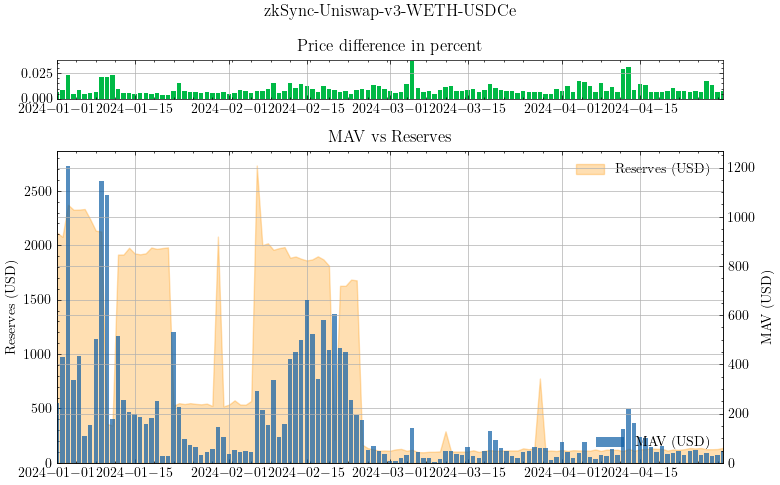

In [16]:
plt.style.use('https://raw.githubusercontent.com/garrettj403/SciencePlots/master/scienceplots/styles/science.mplstyle')

fig = plt.figure(figsize=(8,5))

gs1 = gridspec.GridSpec(5, 1)
ax1 = fig.add_subplot(gs1[0:1,0])
ax2 = fig.add_subplot(gs1[1:,0])
ax3 = ax2.twinx()

#fig.suptitle(file1)
fig.suptitle(f'{contract_name}')

#ax1.plot(df_per_day['timestamp'], df_per_day['cum_MAV'], color ='C2')

#ax1.plot(df_per_day.index, df_per_day['price_diff']/df_per_day['spot_price'], 
ax1.bar(df_per_day['block_timestamp'], abs(df_per_day['price_diff']), 
        color = 'C1',
        label = r'Price Difference (\%)')

ax2.fill_between(df_per_day['block_timestamp'],0, df_per_day['reserve_total_USD'], 
        color ='C2', alpha =0.3,
        label = f'Reserves (USD)')

ax3.bar(df_per_day['block_timestamp'], df_per_day['max_MAV_USD'],
        label = f'MAV (USD)', alpha=0.7)
#.rolling(window).var()

ax2.set_ylim(0)
for a in [ax1, ax2]:
    a.set_xlim(min(df_per_day['block_timestamp']),max(df_per_day['block_timestamp']))

ax1.set_ylabel('%')

ax2.set_ylabel(f'Reserves (USD)')
ax3.set_ylabel(f'MAV (USD)')

ax1.set_title("Price difference in percent")
ax2.set_title("MAV vs Reserves")
#ax1.legend(loc=3)
ax3.legend(loc=4)
ax2.legend(loc=1)

ax1.grid()
ax2.grid()
ax3.grid()

gs1.tight_layout(fig)


fig.savefig(f"./plots/{contract_name}_mav.pdf")

plt.show()

